In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load the data and assign to X and y
train = pd.read_csv('../data/train.csv')
X_test = pd.read_csv('../data/test.csv')

X_train = train.drop(labels = ["label"],axis = 1) 
y_train = train["label"]

# Now normalize the test and train sets
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

In [3]:
# What are the sizes of the train and test sets?
print('train size: ' + str(len(X_train)) + ', test size: ' + str(len(X_test)))

train size: 42000, test size: 28000


In [4]:
# So we have 42,000 train images and 28,000 test images
# let's go ahead and print one
print(X_train[0].shape)

(28, 28, 1)


(28, 28, 1)


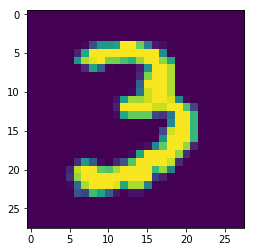

In [5]:
# Let's now reshape it into a 28 x 28 matrix
image = X_train[9]
print(image.shape)

# Let's plot it now
plt.imshow(image.reshape(28,28))

In [6]:
# Now let's look at the labels
print(y_train.values.shape)
y_train.values.reshape(-1, 1)

(42000,)


array([[1],
       [0],
       [1],
       ...,
       [7],
       [6],
       [9]])

In [7]:
# So the labels are NOT one hot encoded. We need to do that
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
y_train_ohe = enc.fit_transform(y_train.values.reshape(-1, 1))

In [8]:
y_train_ohe.shape

(42000, 10)

In [9]:
# Let's first reset our graph, so our neural network components are all declared within the same graph
ops.reset_default_graph()

In [10]:
# The input, X, is 28 x 28 grayscale (1 color channel) images, and
# I'll break them up into mini-batches of an unknown size at this
# point -- thus the 'None' as the 1st dimension
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
# y_hat, estimates output by the softmax layer
Y_ = tf.placeholder(tf.float32, [None, 10])
# we'll do a variable learning rate
lr = tf.placeholder(tf.float32)

In [11]:
# The number of channels (aka. kernels or filters) that will be
# applied in each convolutional layer
c1 = 6 # first convolutional layer
c2 = 12 # second convolutional layer
c3 = 24 # third convolutional layer

# the size of each filter (5 by 5)
filter_size = 5

# then we'll have one fully connected layer with 200 nodes
f1 = 200

In [12]:
# Time to setup the weights and biases associated with each layer.
# Note how much smaller the number of parameters is as compared with
# a fully connected NN with similar number of layers.

# We'll set W1 with positive values from a Gaussian distribution
# having standard deviation of 0.1

# TODO fully understand this matrix math here
W1 = tf.Variable(tf.truncated_normal([filter_size, filter_size, 1, c1], stddev=0.1))
B1 = tf.Variable(tf.ones([c1])/10)
W2 = tf.Variable(tf.truncated_normal([filter_size, filter_size, c1, c2], stddev=0.1))
B2 = tf.Variable(tf.ones([c2])/10)
W3 = tf.Variable(tf.truncated_normal([filter_size, filter_size, c2, c3], stddev=0.1))
B3 = tf.Variable(tf.ones([c3])/10)

# Now the weights and biases for the fully connected layer. It's
# 7 * 7 * 24 by 200 because the activation matrix after the final
# convolutional layer is 7 x 7 x 24. So all 200 nodes receive 1,176
# inputs.
W4 = tf.Variable(tf.truncated_normal([7 * 7 * c3, f1], stddev=0.1))
B4 = tf.Variable(tf.ones([f1])/10)

# Now for the softmax (output) layer
W5 = tf.Variable(tf.truncated_normal([f1, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)

In [13]:
# Time to build the model! We will perform same padding for each
# convolution, reducing dimensions instead by specifying a stride
# of two for Conv layers 2 and 3
stride = 1  # output is 28x28
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
stride = 2  # output is 14x14
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2  # output is 7x7
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# Flatten the output of the third convolutional layer to go into
# the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 7 * 7 * c3])

# Activation for fully connected layer
Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)

# softmax layer
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

In [14]:
# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cost = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cost = tf.reduce_mean(cost)

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# prediction of the trained model, for classifying the test set
prediction = tf.argmax(Y, 1)

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(lr).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [15]:
len(X_train)

42000

In [16]:
# now let's initialize and run the session!
init = tf.global_variables_initializer()

# TODO here I am!
import time
from sklearn.model_selection import train_test_split

In [20]:
def train(dev_split=0.2, batch_size=500, learning_rate=0.003, 
          epochs=1, predict=True):
    
    training_start = time.time()
    
    with tf.Session() as sess:
        
        # Initialize the variables
        sess.run(init)
        
        # number of batches in an epoch
        batches = int((len(X_train) * (1-dev_split)) // batch_size)
        print("Training", epochs, "epochs with", batches, "batches per epoch.")
        
        for epoch in range(epochs):
            
            epoch_start = time.time()
            epoch_cost = 0
            
            # split the data into a train and dev set for each epoch
            x_train_, x_dev, y_train_, y_dev = train_test_split(X_train, y_train_ohe, test_size=dev_split)
            
            # run this training data through the neural network
            for batch in range(batches):
                
                # Calculate the start and end indices for the next batch
                begin = (batch * batch_size)
                end   = (batch * batch_size) + batch_size

                # Get the next sequential batch from the training data
                batch_xs, batch_ys = x_train_[begin:end], y_train_[begin:end]
                
                # Feed this batch through the neural network.
                _, batch_cost = sess.run([train_step, cost], feed_dict={X: batch_xs, Y_: batch_ys, lr: learning_rate})
                # print(batch_cost)
                epoch_cost += batch_cost
            
            # calculate accuracy and print results of epoch
            train_accuracy, train_cost = sess.run([accuracy, cost], 
                                                  {X: x_train_, Y_: y_train_})
            dev_accuracy, dev_cost = sess.run([accuracy, cost], 
                                                {X: x_dev, Y_: y_dev})
            epoch_time = round(time.time() - epoch_start, 1)
            print("Epoch", epoch+1, "-", epoch_time, "s - train/dev cost:", 
                  round(train_cost, 4), "|", round(dev_cost, 4), 
                  "- train/dev accuracy:", round(train_accuracy, 4), 
                  "|", round(dev_accuracy, 4))
        
        # Generate the predictions on the test set
        if predict:
            predictions = prediction.eval({X: X_test})
        
    print("Total training time:", round(time.time() - training_start, 1), "s")
    
    # Return the predictions
    if predict:
        return predictions
        

In [21]:
predictions = train()

Training 1 epochs with 67 batches per epoch.
Epoch 1 - 73.1 s - train/dev cost: 0.17 | 0.1829 - train/dev accuracy: 0.948 | 0.9467
Total training time: 97.5 s


Pretty good accuracy! Now let's submit our predictions.

### Submitting predictions

The predictions generated by the model is an array of length 28,000:

In [25]:
predictions.shape

(28000,)

Per the competition instructions, we need to submit a .csv file in the format of:

```
ImageId,Label
1,0
2,0
3,0
...
```

To help with this I'll import pandas, create a dataframe with these column headers, and save it to .csv.

In [35]:
import pandas as pd

df_predictions = pd.DataFrame({'ImageId' : np.arange(len(predictions))+1,
                               'Label' : predictions})
df_predictions.head(20)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [36]:
df_predictions.to_csv('tf_cnn_v1_submission.csv', index=False)